In [1]:
import cv2
import numpy as np
import json
import os
import os.path as osp
from pathlib import Path
import matplotlib.pyplot as plt

from core import ObjectDetector, CornerPredictor

In [2]:
dt_vehicle = ObjectDetector('yolov4-default')
dt_plate   = ObjectDetector('yolov4-plate_type')
dt_number  = ObjectDetector('yolov4-plate_number')
dt_corner  = CornerPredictor('corner_prediction')

<yolov4-default> model loaded.
<yolov4-plate_type> model loaded.
<yolov4-plate_number> model loaded.
<corner_prediction> model loaded.


In [8]:
dataset_dir = r'D:\User Profiles\Desktop\Personal Files\School\University Project\myPlateDetection\all_dataset\test_data'
vehicle_dataset = osp.join(dataset_dir, 'vehicle_images')
plate_dataset = osp.join(dataset_dir, 'plate_images')

test_path = [str(p) for p in Path(vehicle_dataset).glob('**/*.jpg') if 'LE_447' in str(p)]
print('total:', len(test_path))

total: 1


In [4]:
def start_V_LP_detection(img):
    pbox, ptype = [], []
    _ = dt_vehicle.loadImage(img)
    bbox1, obj1 = dt_vehicle.runDetection(conf_thrsh=.5, mode='vehicle', multi_res=True)

    if len(bbox1) != 0:
        for box1 in bbox1:
            _ = dt_plate.loadImage(img, True, box1)
            bbox2, obj2 = dt_plate.runDetection(mode='plate')
            if len(bbox2) != 0:
                pbox.append(np.array([[box1[0, 0]+bbox2[0, 0], box1[0, 1]+bbox2[0, 1]],
                            [box1[0, 0]+bbox2[1, 0], box1[0, 1]+bbox2[1, 1]]]))
                ptype.append(obj2)
    else:
        _ = dt_plate.loadImage(img)
        bbox2, obj2 = dt_plate.runDetection(mode='plate')
        if len(bbox2) != 0:
            pbox.append(bbox2)
            ptype.append(obj2)

    return bbox1, pbox, ptype

In [13]:
def start_LPR(img, pts):
    img_plate = dt_corner.loadImage(img, True, pts)
    img_plate_warped, _ = dt_corner.runPrediction()

    _ = dt_number.loadImage(img_plate_warped)
    bbox3, obj3 = dt_number.runDetection(.5, .3, 'number', True)

    d_number = ''
    if len(bbox3) != 0:
        nb = [obj3[i] for i in bbox3[:, 0, 0].argsort()]
        for n in nb:
            d_number += n

    return img_plate_warped, bbox3, d_number

In [6]:
def drawRectangle(img, bbox):
    for box in bbox:
        cv2.rectangle(img, (box[0, 0], box[0, 1]), (box[1, 0], box[1, 1]), (0, 255, 0), 1)
    plt.imshow(img)

pred: 白底黑字
label: 白底黑字


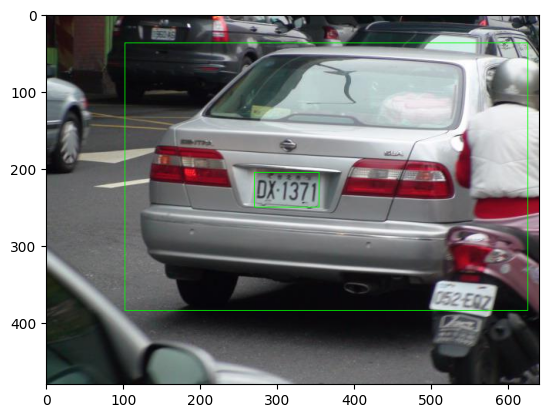

In [10]:
target = 0
p = test_path[0]
img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
box_vehicle, box_plate, plate_type = start_V_LP_detection(img)

if len(box_plate) != 0:
    with open(p.replace('jpg', 'json'), 'r', encoding='utf-8') as f:
        data = json.load(f)
    ptype = data['shapes'][0]['label'] # plate type
    pts = np.array(data['shapes'][0]['points']) # plate points

    offset_x, offset_y = int(0.2*(pts[1, 0]-pts[0, 0])), int(0.2*(pts[1, 1]-pts[0, 1]))
    pts[0, 0], pts[0, 1] = pts[0, 0]-offset_x, pts[0, 1]-offset_y
    pts[1, 0], pts[1, 1] = pts[1, 0]+offset_x, pts[1, 1]+offset_y

    for i, [x, y] in enumerate(pts):
        if x < 0: x = 0 
        elif x >= img.shape[1]: x = img.shape[1]-1           
        if y < 0: y = 0
        elif y >= img.shape[0]: y = img.shape[0]-1
        pts[i] = [x, y]

    for i in range(len(box_plate)):
        if pts[0, 0] <= box_plate[i][0, 0] and pts[0, 1] <= box_plate[i][0, 1]\
            and pts[1, 0] >= box_plate[i][1, 0] and pts[1, 1] >= box_plate[i][1, 1]:
            target = i
            break

print('pred:', plate_type[target])
print('label:', ptype)

if len(box_vehicle) != 0:
    drawRectangle(img, [box_vehicle[target]])
if len(box_plate) != 0:
    drawRectangle(img, [box_plate[target]])

pred: DX1371
label: DX1371


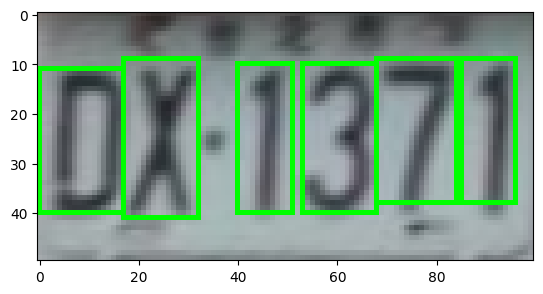

In [14]:
p = test_path[0]
img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
with open(p.replace('jpg', 'json'), 'r', encoding='utf-8') as f:
    pts = np.array(json.load(f)['shapes'][0]['points']) # plate points

img_plate, bbox, d_number = start_LPR(img, pts)
drawRectangle(img_plate, bbox)

fn = osp.basename(p).split('.')[0]
number_file = osp.join(plate_dataset, fn+'-plate.json')
with open(number_file, 'r') as f:
    nb = [sh['label'] for sh in json.load(f)['shapes']] # plate numbers
number = ''
for n in nb:
    number += n

print('pred:', d_number)
print('label:', number)